<a href="https://colab.research.google.com/github/excelasaph/Data-Preprocessing-Group-11/blob/main/Image_processing%26_Facial_recognition_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install required packages (only once)
!pip install scikit-learn opencv-python xgboost matplotlib seaborn joblib

# Standard imports
import os
import cv2
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn & XGBoost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, log_loss,
    confusion_matrix, classification_report
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


In [3]:
from google.colab import drive
drive.mount('/content/drive')  # optional if your dataset is on Drive


Mounted at /content/drive


In [4]:
base_path = "/content/drive/MyDrive/Dataset"
augmented_dir = "/content/drive/MyDrive/augmented"
os.makedirs(augmented_dir, exist_ok=True)


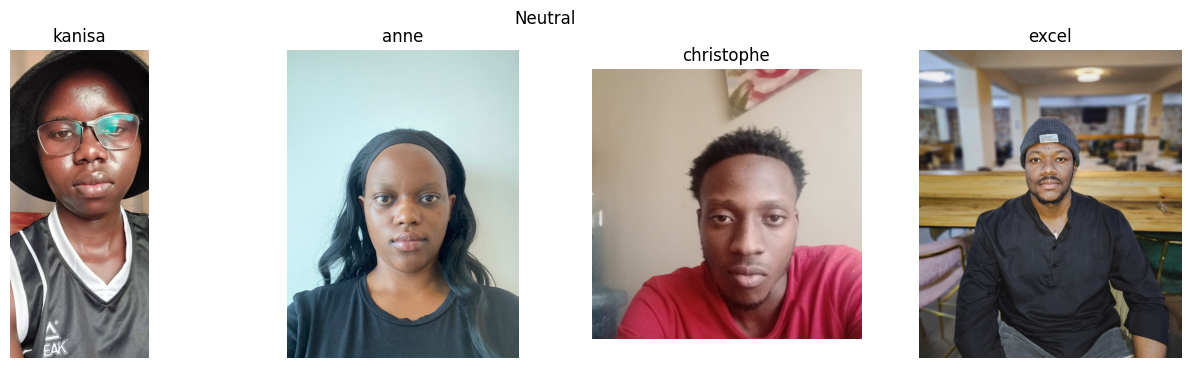

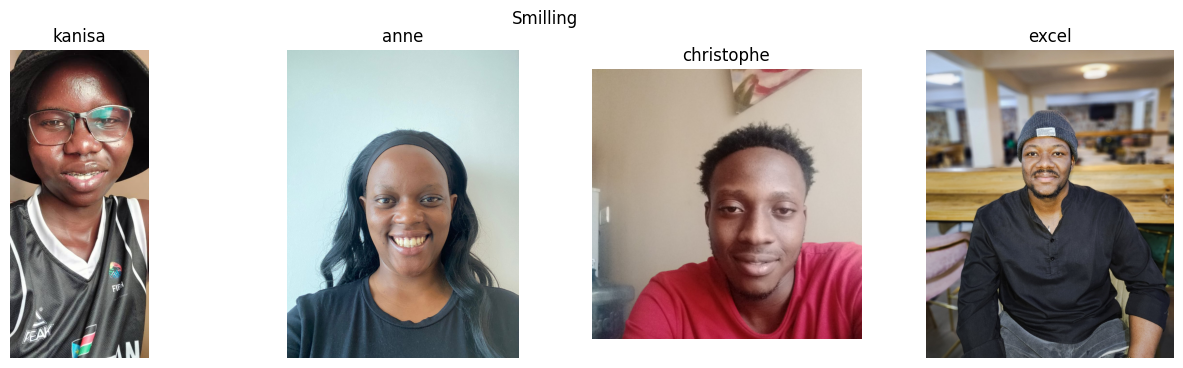

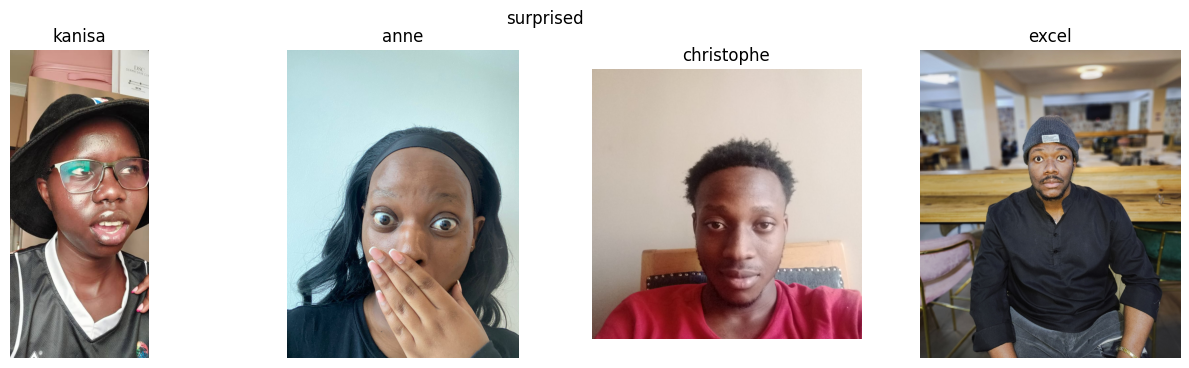

In [5]:
def show_images_from_folder(folder_path, title):
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    for i, filename in enumerate(os.listdir(folder_path)[:4]):
        path = os.path.join(folder_path, filename)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img)
        axs[i].set_title(filename.split('.')[0])
        axs[i].axis('off')
    plt.suptitle(title)
    plt.show()

show_images_from_folder(os.path.join(base_path, "neutral"), "Neutral")
show_images_from_folder(os.path.join(base_path, "smilling"), "Smilling")
show_images_from_folder(os.path.join(base_path, "surprised"), "surprised")


In [6]:


# Standard cleaning and resizing function
def clean_image(image, size=(224, 224)):
    image = cv2.resize(image, size)
    if len(image.shape) == 2:  # grayscale
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    return image

# Augmentation with cleaning applied
def augment_image(image, size=(64, 64)):
    image = clean_image(image, size)
    flipped = clean_image(cv2.flip(image, 1), size)
    rotated = clean_image(cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE), size)
    gray = clean_image(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), size)
    return [image, flipped, rotated, gray]


In [7]:
# Example: Augment and save cleaned training set
def augment_and_save(paths, labels, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for path, label in zip(paths, labels):
        image = cv2.imread(path)
        if image is None:
            continue
        aug_images = augment_image(image)
        base_name = os.path.basename(path).split('.')[0]
        for i, aug in enumerate(aug_images):
            filename = f"{base_name}_{label}_{i}.jpg"
            cv2.imwrite(os.path.join(save_dir, filename), aug)


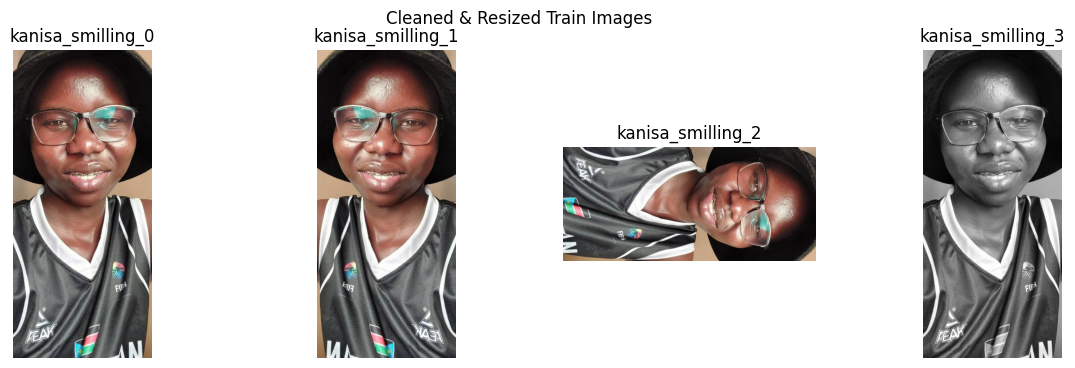

In [8]:
def show_sample_images(folder_path, num_samples=4, title="Preview"):
    files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]
    sample_files = files[:num_samples]

    plt.figure(figsize=(15, 4))
    for i, fname in enumerate(sample_files):
        img = cv2.imread(os.path.join(folder_path, fname))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(fname.split('.')[0])
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Example: Preview cleaned training images
show_sample_images("/content/drive/MyDrive/augmented", title="Cleaned & Resized Train Images")


In [9]:
def extract_features(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (64, 64))
    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256]*3).flatten()
    return hist / np.sum(hist)

features = []
labels = []

for file in os.listdir(augmented_dir):
    if file.endswith('.jpg'):
        label = file.split('_')[1]
        path = os.path.join(augmented_dir, file)
        feat = extract_features(path)
        features.append(feat)
        labels.append(label)

df = pd.DataFrame(features)
df["expression"] = labels
df.to_csv("/content/drive/MyDrive/facial_dataset/image_features.csv", index=False)
print("✅ image_features.csv saved successfully.")


✅ image_features.csv saved successfully.


In [10]:
from sklearn.preprocessing import LabelEncoder

# Fix typo: ensure all labels are valid
df["expression"] = df["expression"].replace("smilling", "smilling")

# Encode expressions into integers
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["expression"])

# Use this numeric label for training
X = df.drop(columns=["expression", "label"])
y = df["label"]



🔍 Training Random Forest...

📊 Random Forest Performance:
Accuracy: 0.8
F1-Score: 0.8
Log Loss: 0.793


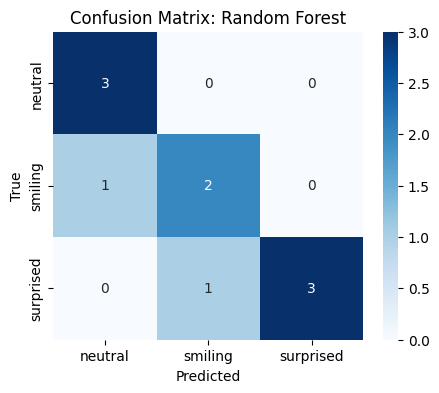


Classification Report:
              precision    recall  f1-score   support

     neutral       0.75      1.00      0.86         3
     smiling       0.67      0.67      0.67         3
   surprised       1.00      0.75      0.86         4

    accuracy                           0.80        10
   macro avg       0.81      0.81      0.79        10
weighted avg       0.82      0.80      0.80        10


🔍 Training Logistic Regression...

📊 Logistic Regression Performance:
Accuracy: 0.1
F1-Score: 0.06
Log Loss: 1.129


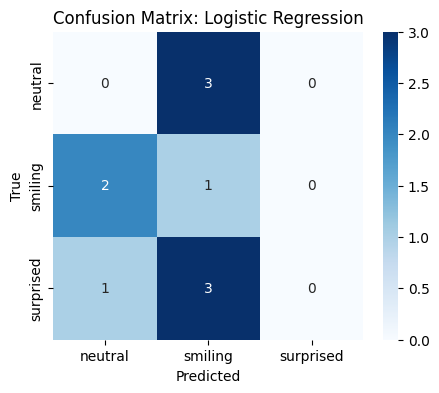


Classification Report:
              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00         3
     smiling       0.14      0.33      0.20         3
   surprised       0.00      0.00      0.00         4

    accuracy                           0.10        10
   macro avg       0.05      0.11      0.07        10
weighted avg       0.04      0.10      0.06        10


🔍 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/xgboost/t


📊 XGBoost Performance:
Accuracy: 0.9
F1-Score: 0.9
Log Loss: 0.644


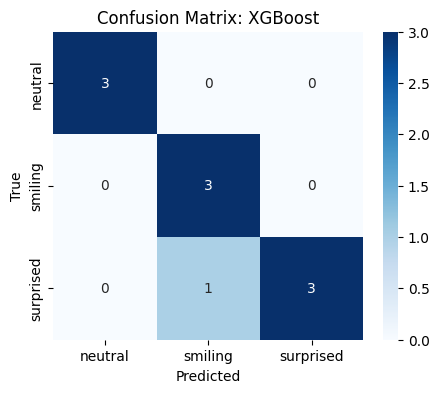


Classification Report:
              precision    recall  f1-score   support

     neutral       1.00      1.00      1.00         3
     smiling       0.75      1.00      0.86         3
   surprised       1.00      0.75      0.86         4

    accuracy                           0.90        10
   macro avg       0.92      0.92      0.90        10
weighted avg       0.93      0.90      0.90        10



In [11]:


# Load features
df = pd.read_csv("/content/drive/MyDrive/image_features.csv")

# Fix label typo if needed
df["expression"] = df["expression"].replace("smilling", "smiling")

# Label Encoding
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["expression"])

# Features and Labels
X = df.drop(columns=["expression", "label"])
y = df["label"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Models to evaluate
models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Track performance
results = []

for name, model in models.items():
    print(f"\n🔍 Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    loss = log_loss(y_test, y_prob)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1-Score": f1,
        "Log Loss": loss,
        "Classifier": model
    })

    print(f"\n📊 {name} Performance:")
    print("Accuracy:", round(acc, 3))
    print("F1-Score:", round(f1, 3))
    print("Log Loss:", round(loss, 3))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


📈 Model Comparison:


,Model,Accuracy,F1-Score,Log Loss
2,XGBoost,0.9,0.90,0.644472
0,Random Forest,0.8,0.80,0.793362
1,Logistic Regression,0.1,0.06,1.129316


/tmp/ipython-input-15-3245928749.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="F1-Score", palette="viridis")


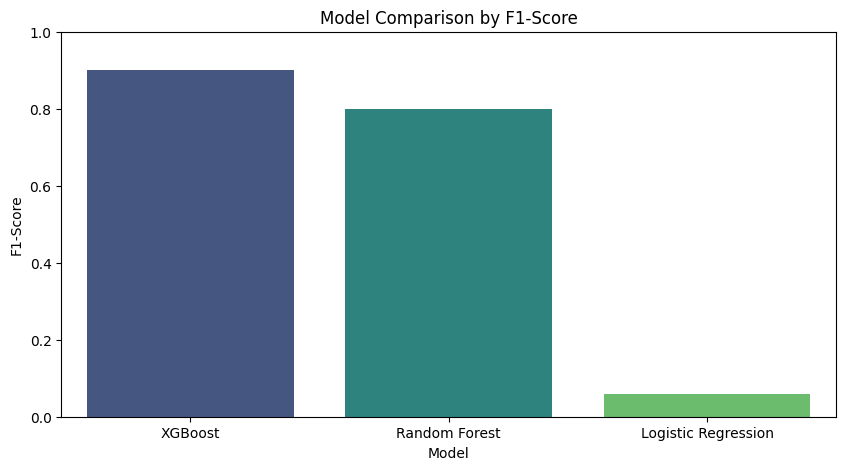


✅ Best model saved as: facial_recognition_xgboost.joblib


In [15]:
# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)

# Display comparison
print("\n📈 Model Comparison:")
display(results_df[["Model", "Accuracy", "F1-Score", "Log Loss"]])

# Bar Plot
plt.figure(figsize=(10,5))
sns.barplot(data=results_df, x="Model", y="F1-Score", palette="viridis")
plt.title("Model Comparison by F1-Score")
plt.ylim(0, 1)
plt.ylabel("F1-Score")
plt.show()

# Save best model
best_model = results_df.iloc[0]["Classifier"]
best_model_name = results_df.iloc[0]["Model"].replace(" ", "_").lower()
joblib.dump(best_model, f"/content/drive/MyDrive/facial_recognition_{best_model_name}.joblib")

print(f"\n✅ Best model saved as: facial_recognition_{best_model_name}.joblib")


Classification Report:
              precision    recall  f1-score   support

     neutral       1.00      1.00      1.00         3
     smiling       0.75      1.00      0.86         3
   surprised       1.00      0.75      0.86         4

    accuracy                           0.90        10
   macro avg       0.92      0.92      0.90        10
weighted avg       0.93      0.90      0.90        10



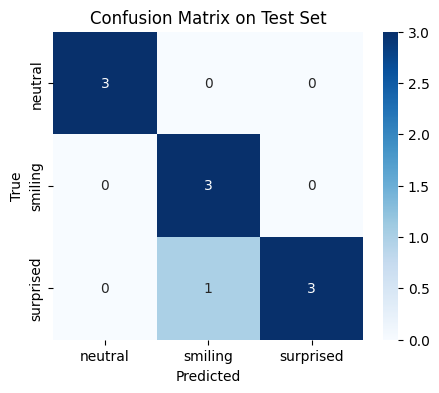

In [16]:


# 🔁 Load model
model_path = "/content/drive/MyDrive/facial_recognition_xgboost.joblib"
model = joblib.load(model_path)

# 🧪 Predict
y_pred = model.predict(X_test)

# ✅ Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
def extract_features(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (64, 64))
    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256]*3).flatten()
    return hist / np.sum(hist)

# Example: pick one test image from your dataset
new_img_path = "anne.jpg"
features = extract_features(new_img_path)

# Reshape for single sample
features = features.reshape(1, -1)

# Predict with loaded model
prediction = model.predict(features)
predicted_class = label_encoder.inverse_transform(prediction)[0]

print(f"🧠 Model Prediction: {predicted_class}")


🧠 Model Prediction: smiling
